# Использование глубинного обучения для оптимизации портфеля ценных бумаг

## Введение

В этом исследовании мы рассмотрим применение машинного обучения и глубинного обучения для прогнозирования доходности акций и формирования оптимального инвестиционного портфеля. Результаты сравним с базовой стратегией «__Купи и держи__» и оценим эффективность предложенных подходов с помощью ключевых финансовых метрик:

- ##### Коэффициент Шарпа (Sharpe ratio)
    $$
    \text{Sharpe ratio} = \frac{R_p - R_f}{\sigma_p}
    $$

    где:
    - $R_p$ – средняя доходность портфеля
    - $R_f$ – безрисковая ставка доходности
    - $\sigma_p$– волатильность доходности портфеля

- ##### Коэффициент Сортино (Sortino ratio)
    $$
    \text{Sortino ratio} = \frac{R_p - R_f}{\sigma_{downside}}
    $$

    где:
    - $R_p$ – средняя доходность портфеля
    - $R_f$ – безрисковая ставка доходности
    - $\sigma_{downside}$ – стандартное отклонение __отрицательных__ доходностей

- ##### Максимальная просадка (Max drawdown)
    $$
    \text{Max DD} = \max_{t \in [0,T]} \left(\frac{V_{peak} - V_{t}}{V_{peak}}\right)
    $$

    где:
    - $V_{peak}$ – максимальное историческое значение стоимости портфеля
    - $V_{t}$ – стоимость портфеля на момент времени $t$

Импортируем необходимые модули и библиотеки.

In [1]:
import pandas as pd
import numpy as np
import random
from src.utils import *

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.download import MOEXCandlesFetcher
from src.baseline import BaselineBacktest
from src.anomaly_detector import AnomalyDetector
from src.signal_classifier import SignalClassifier
from src.prepare_dataloaders import FinTSDataloaders
from src.lstm_forecast import LSTMForecaster
from src.trainer import Trainer

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(123)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

## Загрузка исторических данных с Московской биржи

Для анализа были выбраны 8 крупнейших российских компаний из разных отраслей (таблица ниже). Данные загружаются за период с 1 января 2015 года по вчерашний день с помощью класса `MOEXCandlesFetcher`. Полученные данные сохраняются в .csv файл для дальнейшего использования.

| Тикер | Компания            | Отрасль                 |
|-------|---------------------|-------------------------|
| YNDX, YDEX | Яндекс              | Информационные технологии |
| FIVE, X5, MGNT | X5 Group, Магнит | Потребительский сектор (розничная торговля) |
| ABRD  | Абрау-Дюрсо         | Потребительский сектор (производство напитков) |
| LKOH, GAZP | Лукойл, Газпром     | Энергетика и добыча сырья |
| SBER  | Сбер                | Финансовый сектор       |
| CHMF  | Северсталь          | Металлургия и добыча сырья |

In [3]:
TICKERS = ["YNDX", "YDEX", "FIVE", "X5", "LKOH", "MGNT", "ABRD", "GAZP", "SBER", "CHMF"]

data_path = "./data/moex_data_test.csv"
fetcher = MOEXCandlesFetcher()
df = fetcher.run(data_path=data_path, tickers=TICKERS, from_date="2015-01-01")

Загружены ранее скачанные данные ./data/moex_data_test.csv.


Посмотрим на случайную выборку и заполним пропуски:

In [4]:
df.sample(5)

,ticker,date,open,low,high,close,volume
15119,SBER,2023-07-13,247.97,245.34,248.15,246.19,29561460
7732,GAZP,2025-01-29,137.78,136.00,139.00,137.05,32928780
16678,X5,2022-07-04,957.00,957.00,1031.00,1029.00,107028
12531,MGNT,2023-07-21,5495.00,5410.00,5745.00,5733.00,893018
13095,SBER,2015-07-08,68.51,66.50,68.94,67.73,160173700


In [5]:
df.isna().sum()

ticker      0
date        0
open      633
low       633
high      633
close     633
volume      0
dtype: int64

In [6]:
data = df.ffill().bfill()
data.isna().sum()

ticker    0
date      0
open      0
low       0
high      0
close     0
volume    0
dtype: int64

Визуализируем __историю цен закрытия__ по всем тикерам.

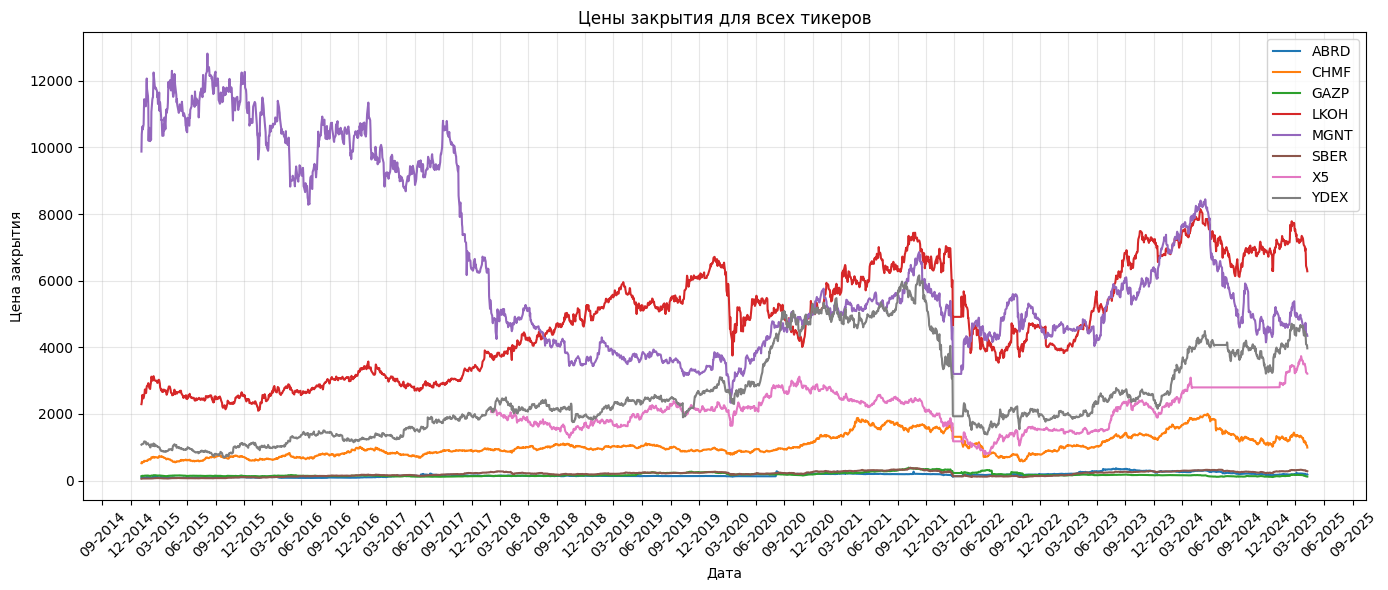

In [7]:
plot_close_prices(df=data)

## Реализация бейзлайн стратегии "Купи и держи"

Делаем бэктест стратегии "Купи и держи" на последних 10% данных каждого тикера и смотрим на перфоманс равновесного портфеля.

In [8]:
baseline_backtester = BaselineBacktest(df=data, close_price="close")

total_pf_df, total_pf_value, pf_return = baseline_backtester.buy_and_hold_performance(test_split_ratio=0.1,
                                                                                      init_cash=100_000)

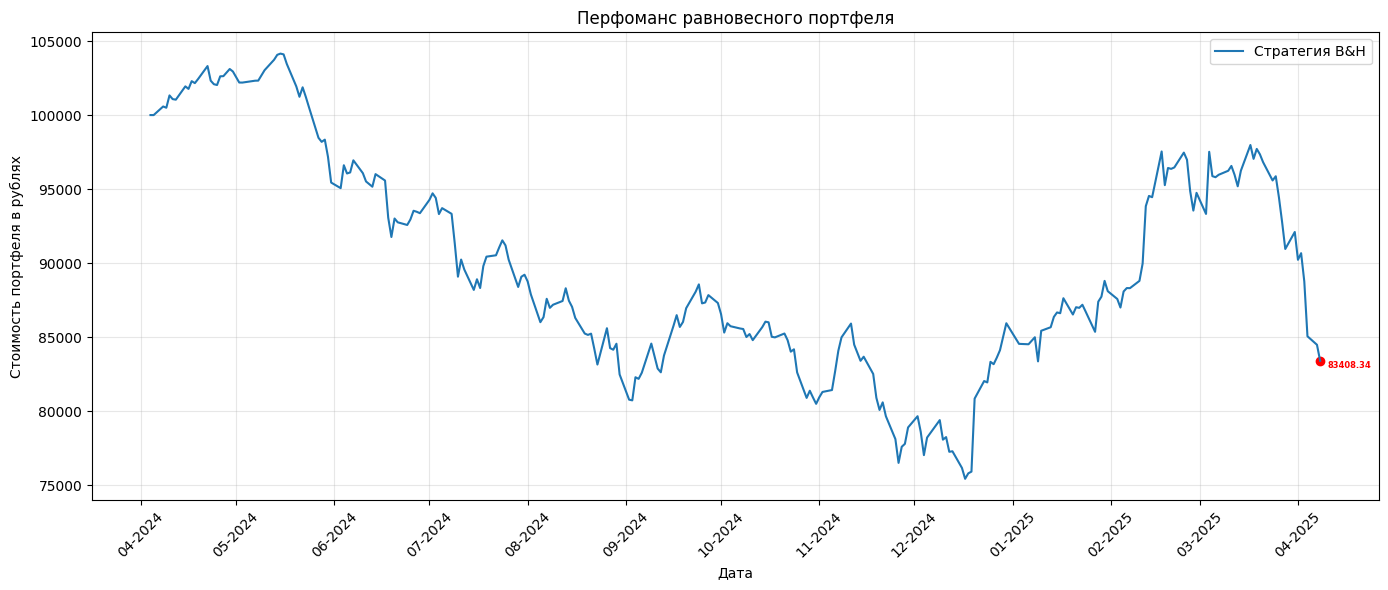

In [9]:
plot_equity(equity_series={"Стратегия B&H": total_pf_value}, 
            title="Перфоманс равновесного портфеля", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

In [10]:
baseline_portfolio, baseline_metrics = baseline_backtester.run_backtest(init_cash=100_000)
baseline_metrics

{'Sharpe Ratio': -0.7925811675169829,
 'Sortino Ratio': -1.139176692835331,
 'Max Drawdown [%]': 27.569049458637345,
 'Total Return [%]': -16.59166}

> __Вывод:__  
>Результаты стратегии «Купи и держи» показывают отрицательную доходность (-16.59%), низкие значения коэффициентов Шарпа (-0.79) и Сортино (-1.14), а также значительную максимальную просадку (27.57%). Это указывает на низкую эффективность и высокий риск такого подхода на рассматриваемом периоде.

In [11]:
assert (round(total_pf_value, 2) - round(baseline_portfolio.value(), 2)).sum() == 0.0

## Реализация стратегии на bullish и bearish сигналах

Перейдем к реализации стратегии на сигналах. Сначала сделаем небольшой Feature engineering - с помощью класса `AnomalyDetector` создадим 2 признака: "anomaly_score" и "anomaly".

In [12]:
custom_params = {
    "n_estimators": 500,
    "contamination": 0.1,
    "n_jobs": -1,
    "random_state": 42,
    }

anomaly_detector = AnomalyDetector(df=data, model_params=custom_params)
extended_df, features = anomaly_detector.generate_features()

In [13]:
df_with_anomalies = anomaly_detector.detect_anomalies(train_period_end="2024-12-31")
df_with_anomalies.tail()

,ticker,date,open,low,high,close,volume,return,amplitude,anomaly_score,anomaly
19943,YDEX,2025-04-02,4348.0,4343.5,4435.0,4409.0,737581,0.012283,0.021066,-0.129297,0
19944,YDEX,2025-04-03,4416.0,4211.0,4434.0,4291.0,859790,-0.026763,0.052957,-0.044962,0
19945,YDEX,2025-04-04,4295.0,4067.0,4313.0,4088.0,1439457,-0.047308,0.060487,0.034069,1
19946,YDEX,2025-04-07,4075.0,3901.0,4368.0,4069.0,2868717,-0.004648,0.119713,0.105425,1
19947,YDEX,2025-04-08,4100.0,3925.0,4143.0,3969.5,1102042,-0.024453,0.055541,-0.039807,0


Посмотрим на аномалии и убедимся, что модель действительно работает. 

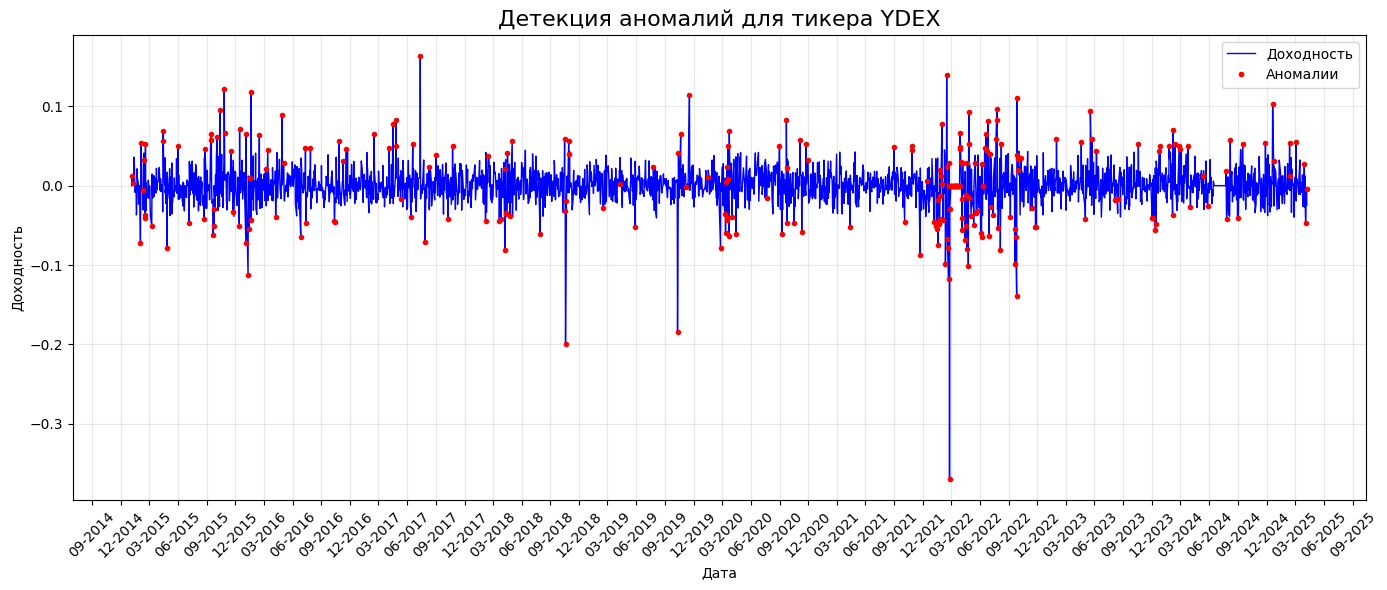

In [14]:
anomaly_detector.visualize_anomalies(ticker="YDEX", is_interactive=False)

Для того, чтобы классификатор адекватно работал, необходимо сгенерировать больше признаков, а также разметить целевую переменную (bullish и bearish сигналы).

In [15]:
gen_features = [
    "momentum_5", "momentum_10",
    "std_5", "std_10",
    "bollinger_bands_20", "bollinger_width_20",
    "atr_14", "atr_7",
    "volume_ratio_10", "volume_ratio_20", "volume_ratio_5",
    "amplitude_mean_10", "amplitude_mean_5",
    "rsi_14", "rsi_7",
    "ema_10", "ema_20", 
    "sma_10", "sma_20",
    "return_lag_10", "return_lag_20"
]

Существует несколько стратегий определения bullish/bearish сигналов:
- Стратегия на основе порогов доходности;
- Стратегия на основе пересечения скользящих средних;
- Стратегия на основе технических индикаторов;
- Стратегия на основе волатильности;
- и др.

В данной работе рассматривается __стратегия на основе волатильности__, так как она подходит для рынков с выраженной волатильностью, коим и является российский рынок в настоящее время.

__Идея__:
- Сначала вычисляется будущая доходность акций на горизонте $N$ дней (`future_return`) и текущая волатильность за последние 20 дней (`rolling_sigma`);
- На основе волатильности устанавливаются динамические пороги (+-5% от rolling_sigma) для формирования bullish, bearish, нейтрального сигналов;
- Затем формируется многоклассовый таргет: `-1 (bearish)`, `0 (нейтральный)`, `1 (bullish)`;
- Нейтральные сигналы исключаются из дальнейшего анализа, и модель CatBoost обучается только на bullish и bearish сигналах через последовательное временное разбиение данных.

In [16]:
signal_classifier = SignalClassifier(df_with_anomalies, features=gen_features, lookahead=10)

Проверим сбалансированность классов:

In [17]:
signal_classifier.check_class_balance()

Баланс классов по тикерам:
ABRD:
target
-1    1285
 1    1130
Name: count, dtype: int64

CHMF:
target
 1    1348
-1    1177
Name: count, dtype: int64

GAZP:
target
 1    1295
-1    1233
Name: count, dtype: int64

LKOH:
target
 1    1376
-1    1158
Name: count, dtype: int64

MGNT:
target
-1    1312
 1    1214
Name: count, dtype: int64

SBER:
target
 1    1436
-1    1090
Name: count, dtype: int64

X5:
target
 1    797
-1    782
Name: count, dtype: int64

YDEX:
target
 1    1357
-1    1151
Name: count, dtype: int64



In [18]:
signal_classifier.train(test_split_ratio=0.1, n_folds=5, gap=5)

proba, signals = signal_classifier.evaluate(bull_threshold=0.5, bear_threshold=0.5)

Дата разделения train/test: 2024-04-03
Оптимальное количество итераций: 29
0:	learn: 0.4565190	total: 24.9ms	remaining: 698ms
28:	learn: 0.5433561	total: 615ms	remaining: 0us


In [19]:
signals["signal"].value_counts()

signal
 1    1392
-1     650
Name: count, dtype: int64

Посмотрим на топ-10 важных признаков:

In [20]:
feat_importance = signal_classifier.feature_importance()
feat_importance.head(10)

,Feature Id,Importances
0,atr_14,13.941829
1,ticker,11.719009
2,rsi_14,11.126890
3,bollinger_width_20,8.816098
4,ema_10,7.049495
5,std_10,5.951675
6,atr_7,4.306266
7,ema_20,4.104495
8,rsi_7,3.850258
9,momentum_10,3.606471


In [21]:
signal_portfolio, signal_metrics = signal_classifier.run_backtest(signals_df=signals, init_cash=100_000)
signal_metrics

{'Sharpe Ratio': -0.7819877628048575,
 'Sortino Ratio': -1.054592721354637,
 'Max Drawdown [%]': 49.332003988035886,
 'Total Return [%]': -31.307100070766598}

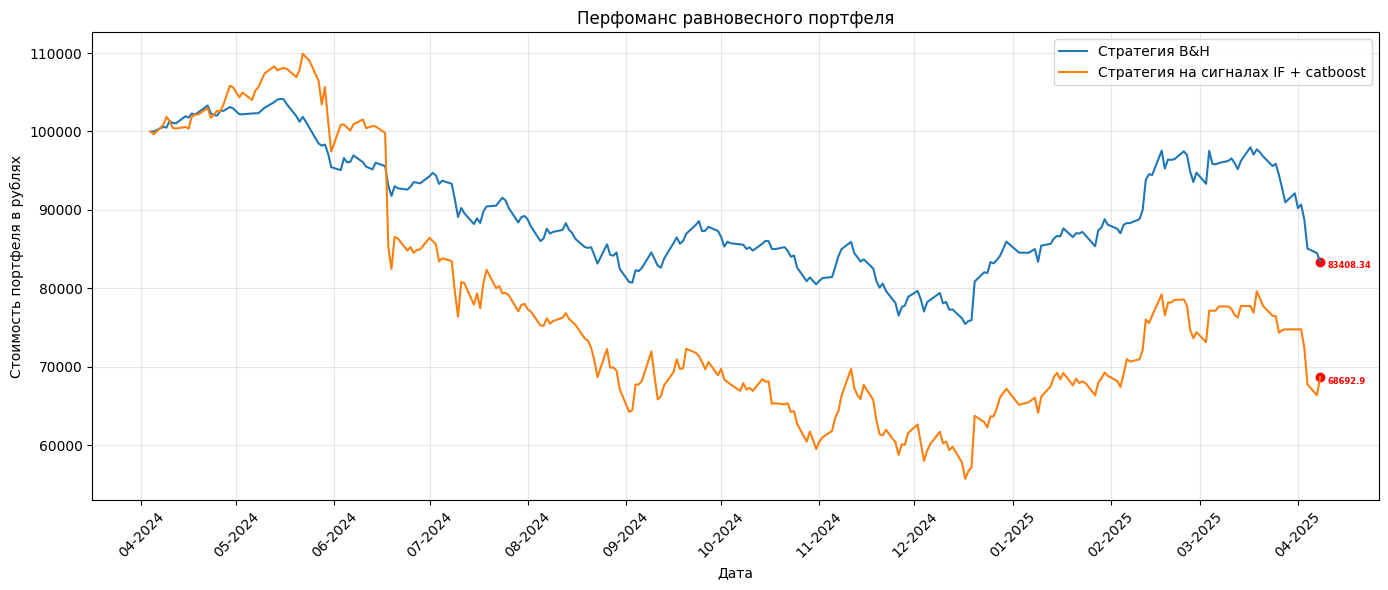

In [22]:
plot_equity(equity_series={"Стратегия B&H": total_pf_value, 
                           "Стратегия на сигналах IF + catboost" : signal_portfolio.value()}, 
            title="Перфоманс равновесного портфеля", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

> __Вывод:__  
> Стратегия на сигналах продемонстрировала крайне низкие метрики по сравнению с бейзлайн стратегией «купи и держи». У стратегии на сигналах значительная потеря капитала (-31.31% против -16.59%), более глубокая просадка (49.33% против 27.57%) и худшие коэффициенты Шарпа и Сортино.

## CNN+LSTM модель прогнозирования доходностей

Особенность данной стратегии заключается в том, что помимо прочих признаков в LSTM необходимо передавать матрицу корреляций между тикерами, которая рассчитывается по определенному окну.
С помощью класса `FinTSDataloaders` можно подготовить dataloader'ы для LSTM, в которых создаются корреляционные матрицы и масштабируются прочие признаки.

In [23]:
loader_creator = FinTSDataloaders(df=data, window=60, forecast_horizon=7, batch_size=128)
train_loader, val_loader, test_loader, feature_scaler, target_scaler = loader_creator.get_loaders()

In [24]:
X_batch, corr_batch, y_batch = next(iter(train_loader))
feature_dim = X_batch.shape[2]
num_tickers = y_batch.shape[1]

print(f"X batch:            {X_batch.shape}")
print(f"Corr matrix batch:  {corr_batch.shape}")
print(f"y batch:            {y_batch.shape}")
print(f"Feature dim:        {feature_dim}")
print(f"Num tickers:        {num_tickers}")

X batch:            torch.Size([128, 60, 112])
Corr matrix batch:  torch.Size([128, 60, 8, 8])
y batch:            torch.Size([128, 8])
Feature dim:        112
Num tickers:        8


Для обучения, валидации и тестирования моделей глубинного обучения реализован класс `Trainer`.

In [25]:
lstm_model = LSTMForecaster(feature_dim=feature_dim, num_tickers=num_tickers).to(DEVICE)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

lstm_trainer = Trainer(lstm_model, criterion, optimizer, scheduler, DEVICE)

In [26]:
train_losses, val_losses = lstm_trainer.train(train_loader, val_loader, epochs=100, patience=20)

Эпоха [10/100] | Train loss: 0.513151 | Val loss: 0.723506
Эпоха [20/100] | Train loss: 0.360293 | Val loss: 0.599419
Эпоха [30/100] | Train loss: 0.286393 | Val loss: 0.570228
Эпоха [40/100] | Train loss: 0.254105 | Val loss: 0.552927
Эпоха [50/100] | Train loss: 0.220941 | Val loss: 0.516882
Эпоха [60/100] | Train loss: 0.207268 | Val loss: 0.529491
Ранняя остановка на эпохе 71


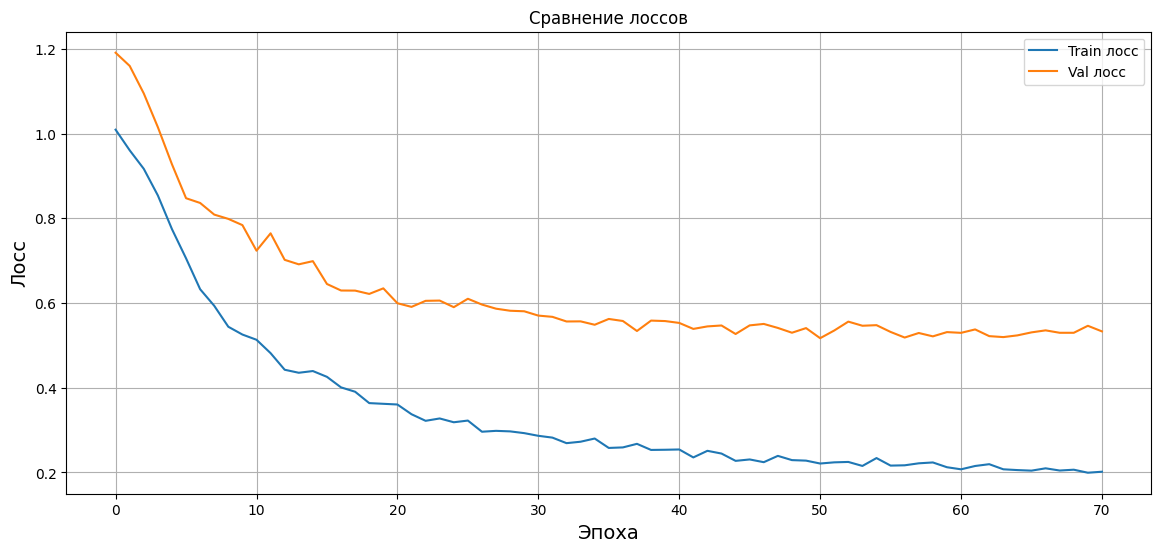

In [27]:
plot_losses(train_losses, val_losses)

In [28]:
test_loss = lstm_trainer.evaluate(test_loader)

test_preds, test_targets, lower_bounds, upper_bounds = lstm_trainer.predict(test_loader, target_scaler, train_loader, ci_coef=1)

Test loss: 0.526385


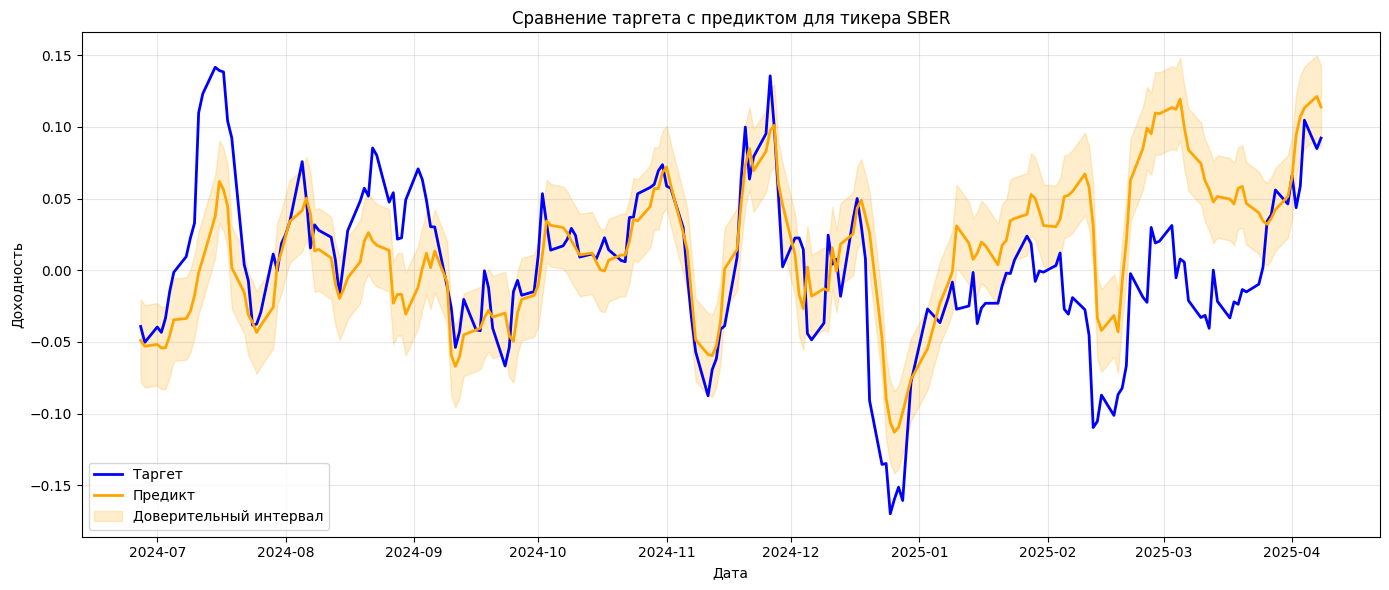

In [29]:
ticker = "SBER"

plot_lstm_predictions(df=data,
                      dataloader=test_loader,
                      ticker=ticker,
                      preds=test_preds,
                      targets=test_targets,
                      lower_bounds=lower_bounds,
                      upper_bounds=upper_bounds)

In [30]:
lstm_portfolio, lstm_metrics = lstm_trainer.run_backtest(df=data, test_preds=test_preds, signal_threshold=0, init_cash=100_000)
lstm_metrics

{'Sharpe Ratio': 0.1307228733640116,
 'Sortino Ratio': 0.20376025031823164,
 'Max Drawdown [%]': 22.950458135984118,
 'Total Return [%]': -0.7900741786147846}

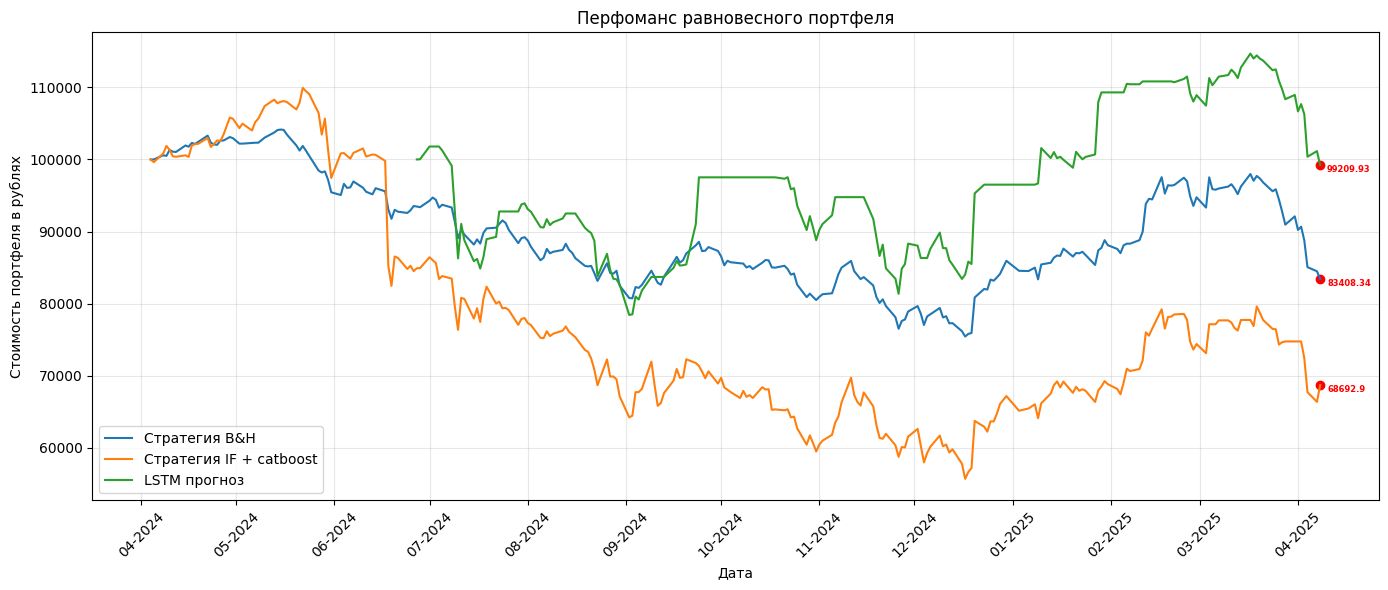

In [31]:
plot_equity(equity_series={"Стратегия B&H": total_pf_value, 
                           "Стратегия IF + catboost" : signal_portfolio.value(),
                           "LSTM прогноз" : lstm_portfolio.value()
                           }, 
            title="Перфоманс равновесного портфеля", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

> __Вывод:__  
> LSTM модель превосходит обе предыдущие стратегии по всем ключевым метрикам. Коэффициенты Шарпа и Сортино положительные, что указывает на приемлемое соотношение доходности к риску. Значительно меньшая максимальная просадка (22.95%), демонстрирующая лучшее управление рисками. Итоговая общая доходность близка к нейтральной (-0.79%), что лучше по сравнению с прошлыми стратегиями, несмотря на небольшой убыток.  
  
> Можно обратить внимание на то, что перфоманс портфеля CNN+LSTM начинается примерно с конца июня 2024 года в отличие от двух прошлых стратегий. Это связано с тем, что матрица корреляций рассчитывается по окну в 60 дней, следовательно, происходит gap в 60 дней.